# The `tub-north` simulations

This notebook contains preliminary analysis for the `tub-north` simulations. These simulations use a northern hemisphere sector domain to test buoyancy wind-driven gyres in MOM6. Wind forcing is achieved through a zonal wind stress that has maximum value ($\tau_0$) at mid-latitudes. Thermal forcing is achieved by restoring towards a prescribed SST profile, at a rate proportional to `FLUXCONST`. The southern boundary and upper several hundred meters have elevated diffusivity.

#### The code in this notebook assumes that `ProcessData.ipynb` has been used to generate averaged and timeseries netcdf files ready to plot.

## Cases run so far
| Run name | wind: $\tau_0$ | `FLUXCONST` | Notes 
|----------|----------|-----------|------
| `tub-north-tx01-fc02` | 0.1 | 0.2 | **Reference case.**
|----------|----------|-----------|------
| `tub-north-tx00-fc02` | 0.0 | 0.2 | Reference buoyancy, No wind. Run from year 0.
| `tub-north-tx00-fc02-pert` | 0.0 | 0.2 | As above, but split from reference at year 1000.
| `tub-north-tx005-fc02` | 0.05 | 0.2 | Weak wind, split from reference at year 1000.
| `tub-north-tx02-fc02` | 0.2 | 0.2 | Strong wind, split from reference at year 1000.
|----------|----------|-----------|------
| `tub-north-tx01-fc00` | 0.1 | 0.0 | No buoyancy flux, split from reference at year 1000.
| `tub-north-tx01-fc005` | 0.1 | 0.05 | Weaker buoyancy flux, split from reference at year 1000.
| `tub-north-tx01-fc01` | 0.1 | 0.1 | Weaker buoyancy flux, split from reference at year 1000.
| `tub-north-tx01-fc03` | 0.1 | 0.3 | Stronger buoyancy flux, split from reference at year 1000.
|----------|----------|-----------|------
| `tub-north-GM` | 0.1 | 0.2 | Reference case, but with GM on.
|----------|----------|-----------|------
| `tub-north` | 0.1 | 0.5 | This was intended as the reference case... buoyancy flux was too strong so not used.
| `tub-north-tx00-fc05` | 0.0 | 0.5 | No wind case. Branched from tub-north at year 110.

## Still to do
* Run GM case with no wind stress.
* Try aa 1° resolution case

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
db='/home/157/amh157/tub-north/tub-north.db'
exptdict = OrderedDict([
    ('tx01-fc00',   {'expt':'tub-north-tx01-fc00','start_time':'1100-01-01'}),
    ('tx01-fc005',   {'expt':'tub-north-tx01-fc005','start_time':'1100-01-01'}),
    ('tx01-fc01',   {'expt':'tub-north-tx01-fc01','start_time':'1100-01-01'}),
    ('tx01-fc03',   {'expt':'tub-north-tx01-fc03','start_time':'1100-01-01'}),
    ('tx00-fc02',   {'expt':'tub-north-tx00-fc02','start_time':'1100-01-01'}),
    ('tx00-fc02-pert',   {'expt':'tub-north-tx00-fc02-pert','start_time':'1100-01-01'}),
    ('tx005-fc02',   {'expt':'tub-north-tx005-fc02','start_time':'1100-01-01'}),
    ('tx01-fc02',   {'expt':'tub-north-tx01-fc02','start_time':'1100-01-01'}),
    ('tx02-fc02',   {'expt':'tub-north-tx02-fc02','start_time':'1100-01-01'}),
    ('GM',   {'expt':'tub-north-GM','start_time':'1100-01-01'})
])
wind_expts = ['tx00-fc02-pert','tx005-fc02','tx01-fc02','tx02-fc02']
buoy_expts = ['tx01-fc00','tx01-fc005','tx01-fc01','tx01-fc02','tx01-fc03']
GM_expts = ['tx01-fc02','GM']
processed = '/g/data/v45/amh157/tub-north-processed/'

# Plotting
This function is for plotting fields on a grid that roughly scales the plot gridcells by their area.



In [3]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[10.1, 10.1],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=10,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

## Spinup Diagnostics
The aim for these runs is to get heat and age stable, and then to branch off perturbations.

Text(0.5,0,'Time (years)')

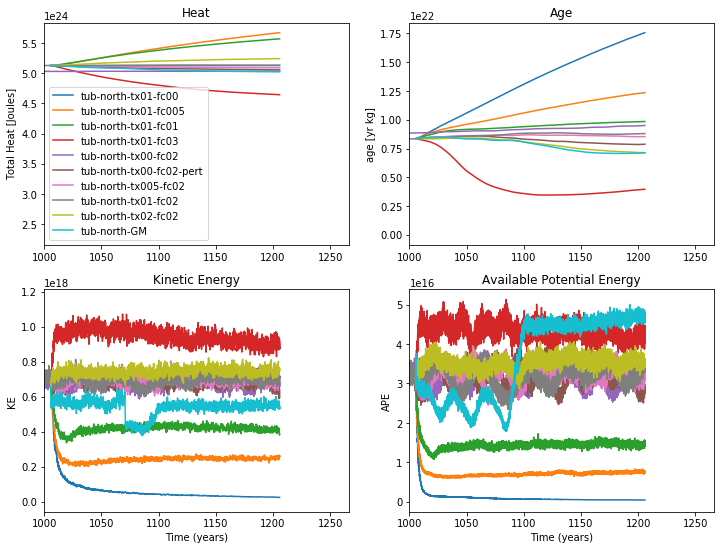

In [8]:
## Spinups
fig, ax = plt.subplots(2,2,figsize=(12,9))

for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    darray = xr.open_mfdataset('/g/data/v45/amh157/mom6/archive/'+expt+'/output*/ocean.stats.nc',decode_times=False).Heat
    darray.coords['Time'] = darray.coords['Time']/365
    darray.plot(ax=ax[0,0], label=expt)

    darray = xr.open_mfdataset('/g/data/v45/amh157/mom6/archive/'+expt+'/output*/ocean.stats.nc',decode_times=False).age
    darray.coords['Time'] = darray.coords['Time']/365
    darray.plot(ax=ax[0,1],label=expt)
    
    darray = xr.open_mfdataset('/g/data/v45/amh157/mom6/archive/'+expt+'/output*/ocean.stats.nc',decode_times=False).KE
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sum('Layer').plot(ax=ax[1,0],label=expt)
    
    darray = xr.open_mfdataset('/g/data/v45/amh157/mom6/archive/'+expt+'/output*/ocean.stats.nc',decode_times=False).APE
    darray.coords['Time'] = darray.coords['Time']/365
    darray.sum('Interface').plot(ax=ax[1,1], label=expt)
    
ax[0,0].set_title('Heat')
ax[0,0].legend()
ax[0,0].set_xlabel('')
ax[0,0].set_xlim(xmin=1000)
ax[1,0].set_xlim(xmin=1000)
ax[0,1].set_xlim(xmin=1000)
ax[1,1].set_xlim(xmin=1000)

ax[0,1].set_title('Age')
ax[0,1].set_xlabel('')
ax[1,0].set_title('Kinetic Energy')
ax[1,0].set_xlabel('Time (years)')
ax[1,1].set_title('Available Potential Energy')
ax[1,1].set_xlabel('Time (years)')

## Mixed Layer Depth

This model creates deep convective mixed layers in the subpolar gyre, in line with the simplified convective physics and forcing. Mixed layer depth shoals a little with stronger wind stress (and with the addition of GM) presumably because the horizontal fluxes from eddies counteracts the convection. Mixed layers deepen with enhanced buoyancy flux, as expected.

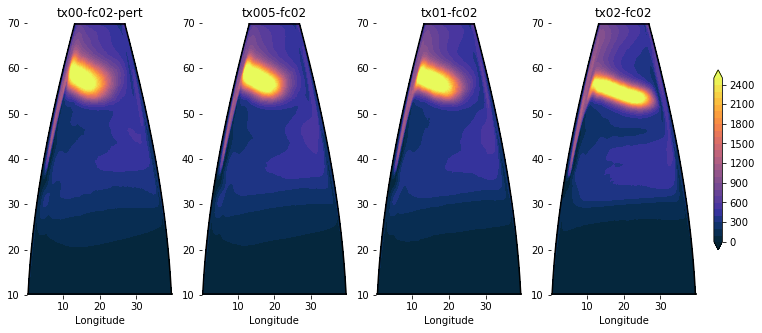

In [4]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,2500,26)
variable = 'mlotst'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD = xr.open_dataset(FileName).mlotst
    X,Y = plot_mercator(ax[ii],MLD.coords['xh'],MLD.coords['yh'])
    p1=ax[ii].contourf(X,Y,MLD,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

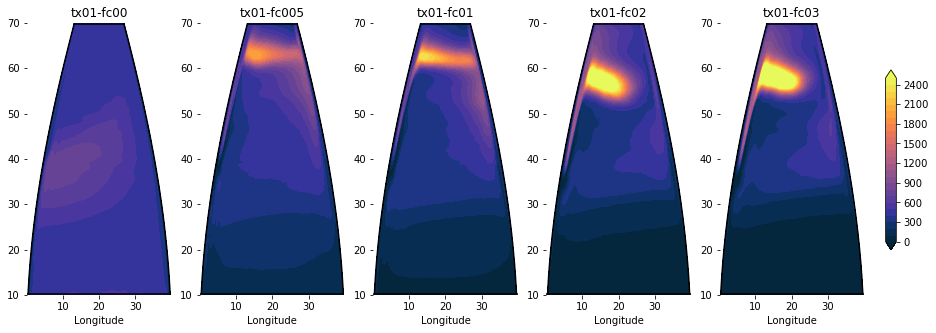

In [8]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(0,2500,26)
variable = 'mlotst'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD = xr.open_dataset(FileName).mlotst
    X,Y = plot_mercator(ax[ii],MLD.coords['xh'],MLD.coords['yh'])
    p1=ax[ii].contourf(X,Y,MLD,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

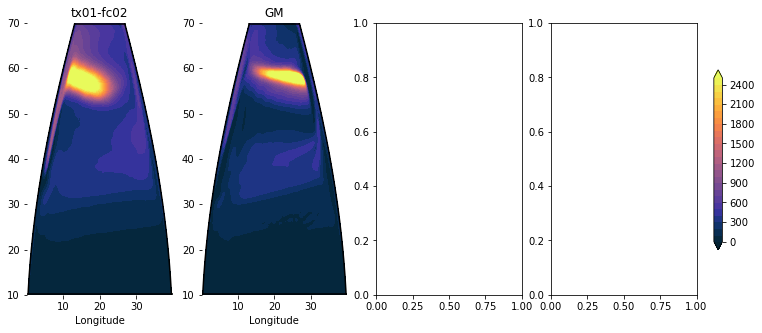

In [9]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,2500,26)
variable = 'mlotst'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    MLD = xr.open_dataset(FileName).mlotst
    X,Y = plot_mercator(ax[ii],MLD.coords['xh'],MLD.coords['yh'])
    p1=ax[ii].contourf(X,Y,MLD,levels=vlev,extend='both',cmap=cm.cm.thermal)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(c) GM Expts')

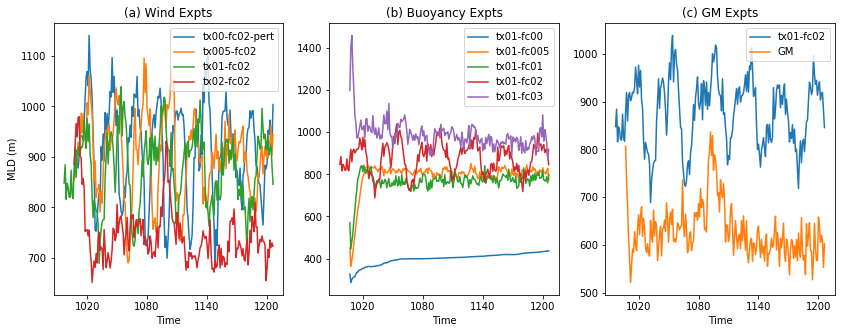

In [10]:
# Timeseries of mean MLD north of 55N
plt.figure(figsize=(14,5))
variable = 'mlotst'
plt.subplot(131)
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_timeseries.nc'
    MLD = xr.open_dataset(FileName).mlotst
    MLD.plot(label=ekey)  
plt.legend()
plt.ylabel('MLD (m)')
plt.title('(a) Wind Expts')
plt.subplot(132)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_timeseries.nc'
    MLD = xr.open_dataset(FileName).mlotst
    MLD.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(b) Buoyancy Expts')
plt.subplot(133)
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_timeseries.nc'
    MLD = xr.open_dataset(FileName).mlotst
    MLD.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(c) GM Expts')

## Heat Flux


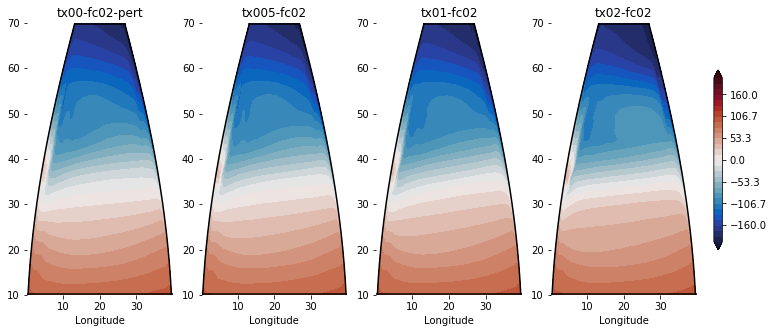

In [11]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-200,200,31)
variable = 'heat_added'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    HF = xr.open_dataset(FileName).heat_added
    X,Y = plot_mercator(ax[ii],HF.coords['xh'],HF.coords['yh'])
    p1=ax[ii].contourf(X,Y,HF,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

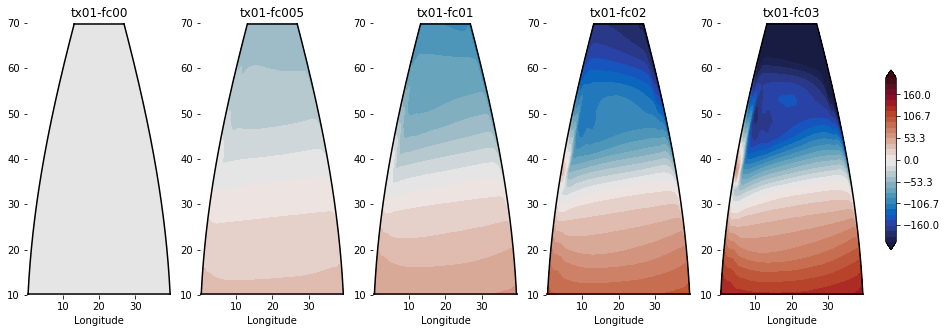

In [12]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(-200,200,31)
variable = 'heat_added'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    HF = xr.open_dataset(FileName).heat_added
    X,Y = plot_mercator(ax[ii],HF.coords['xh'],HF.coords['yh'])
    p1=ax[ii].contourf(X,Y,HF,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

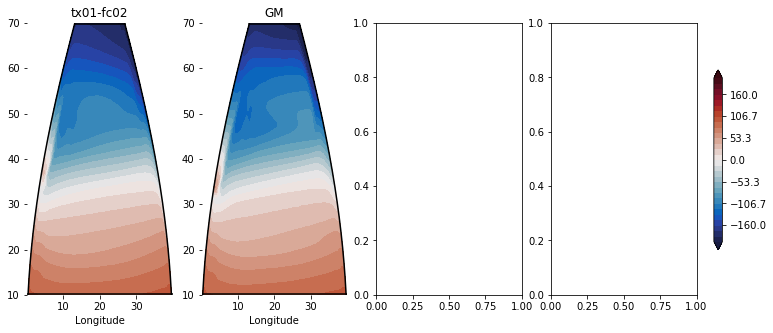

In [13]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-200,200,31)
variable = 'heat_added'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    HF = xr.open_dataset(FileName).heat_added
    X,Y = plot_mercator(ax[ii],HF.coords['xh'],HF.coords['yh'])
    p1=ax[ii].contourf(X,Y,HF,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(f) GM Expts: Subtropical')

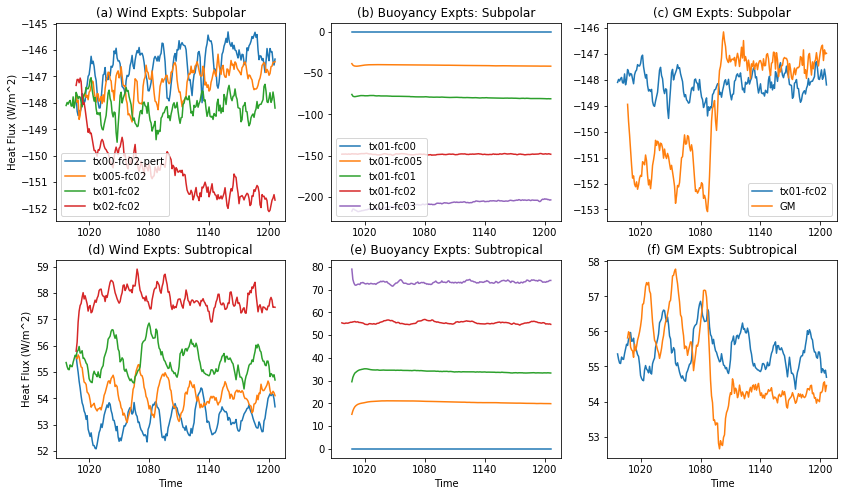

In [23]:
fig,ax = plt.subplots(2,3,figsize=(14,8))
variable = 'heat_added'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added
    HFn.plot(ax=ax[0,0], label=ekey)
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFs = xr.open_dataset(FileName).heat_added
    HFs.plot(ax=ax[1,0],label=ekey)

for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added
    HFn.plot(ax=ax[0,1], label=ekey)
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFs = xr.open_dataset(FileName).heat_added
    HFs.plot(ax=ax[1,1],label=ekey)

    
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_north_timeseries.nc'
    HFn = xr.open_dataset(FileName).heat_added
    Time = cftime.date2num(HFn.Time,units='days since 0001-01-01',calendar='julian')/365
    HFn.plot(ax=ax[0,2], label=ekey)
    FileName = processed+expt+'/'+variable+'_south_timeseries.nc'
    HFs = xr.open_dataset(FileName).heat_added
    HFs.plot(ax=ax[1,2],label=ekey)
    
ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[0,0].set_ylabel('Heat Flux (W/m^2)')
ax[1,0].set_ylabel('Heat Flux (W/m^2)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,2].set_ylabel('')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[0,0].set_title('(a) Wind Expts: Subpolar')
ax[0,1].set_title('(b) Buoyancy Expts: Subpolar')
ax[0,2].set_title('(c) GM Expts: Subpolar')
ax[1,0].set_title('(d) Wind Expts: Subtropical')
ax[1,1].set_title('(e) Buoyancy Expts: Subtropical')
ax[1,2].set_title('(f) GM Expts: Subtropical')

## SSH

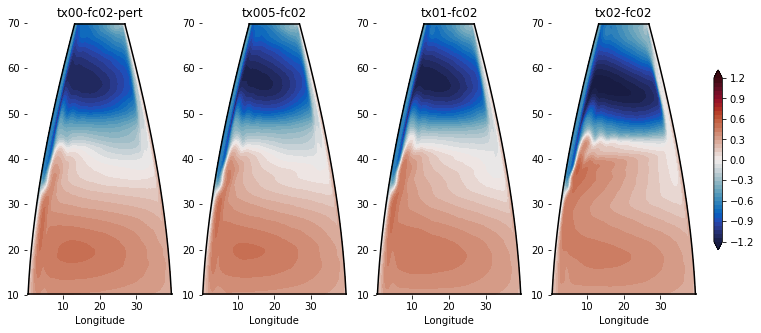

In [15]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-1.2,1.2,41)
variable = 'SSH'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSH = xr.open_dataset(FileName).SSH
    X,Y = plot_mercator(ax[ii],SSH.coords['xh'],SSH.coords['yh'])
    p1=ax[ii].contourf(X,Y,SSH,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

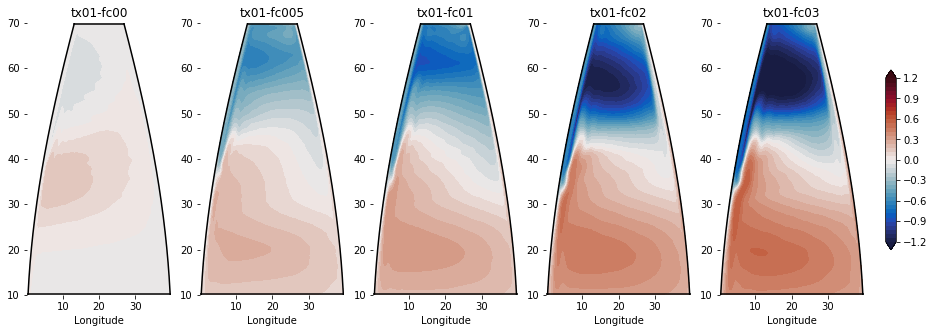

In [16]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(-1.2,1.2,41)
variable = 'SSH'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSH = xr.open_dataset(FileName).SSH
    X,Y = plot_mercator(ax[ii],SSH.coords['xh'],SSH.coords['yh'])
    p1=ax[ii].contourf(X,Y,SSH,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

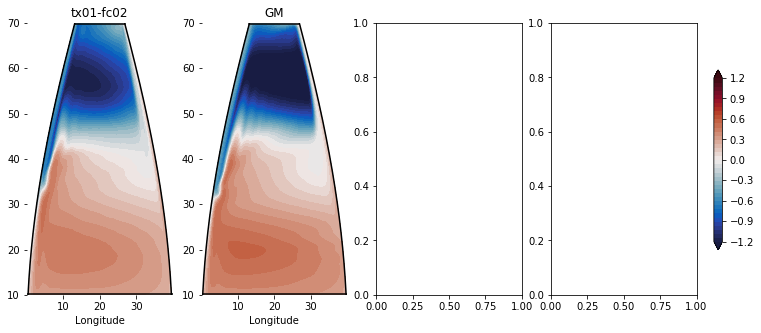

In [17]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-1.2,1.2,41)
variable = 'SSH'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_averaged.nc'
    SSH = xr.open_dataset(FileName).SSH
    X,Y = plot_mercator(ax[ii],SSH.coords['xh'],SSH.coords['yh'])
    p1=ax[ii].contourf(X,Y,SSH,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(f) GM Expts: SSH Maximum')

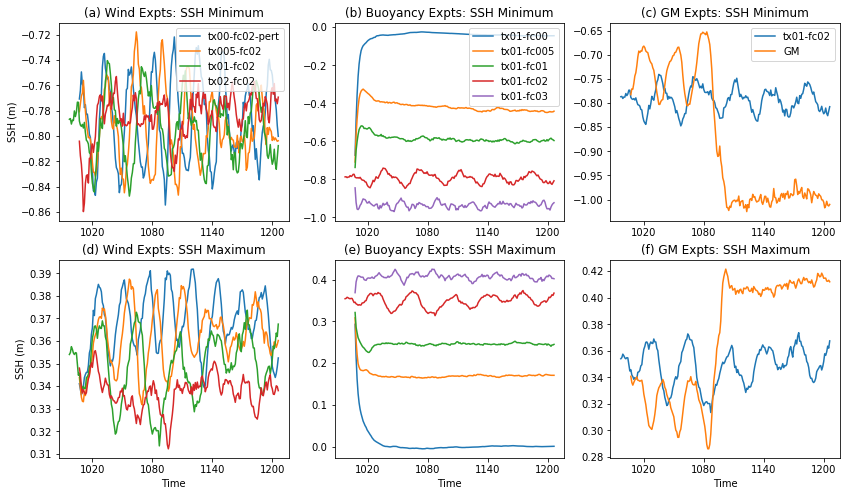

In [24]:
fig,ax = plt.subplots(2,3,figsize=(14,8))
variable = 'SSH'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_min_timeseries.nc'
    SSHmin = xr.open_dataset(FileName).SSH
    SSHmin.plot(ax=ax[0,0], label=ekey)
    FileName = processed+expt+'/'+variable+'_max_timeseries.nc'
    SSHmax = xr.open_dataset(FileName).SSH
    SSHmax.plot(ax=ax[1,0], label=ekey)

for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_min_timeseries.nc'
    SSHmin = xr.open_dataset(FileName).SSH
    SSHmin.plot(ax=ax[0,1], label=ekey)
    FileName = processed+expt+'/'+variable+'_max_timeseries.nc'
    SSHmax = xr.open_dataset(FileName).SSH
    SSHmax.plot(ax=ax[1,1], label=ekey)

for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_min_timeseries.nc'
    SSHmin = xr.open_dataset(FileName).SSH
    SSHmin.plot(ax=ax[0,2], label=ekey)
    FileName = processed+expt+'/'+variable+'_max_timeseries.nc'
    SSHmax = xr.open_dataset(FileName).SSH
    SSHmax.plot(ax=ax[1,2], label=ekey)
    
ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[0,0].set_ylabel('SSH (m)')
ax[1,0].set_ylabel('SSH (m)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,2].set_ylabel('')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[0,0].set_title('(a) Wind Expts: SSH Minimum')
ax[0,1].set_title('(b) Buoyancy Expts: SSH Minimum')
ax[0,2].set_title('(c) GM Expts: SSH Minimum')
ax[1,0].set_title('(d) Wind Expts: SSH Maximum')
ax[1,1].set_title('(e) Buoyancy Expts: SSH Maximum')
ax[1,2].set_title('(f) GM Expts: SSH Maximum')

## Upper ocean streamfunction

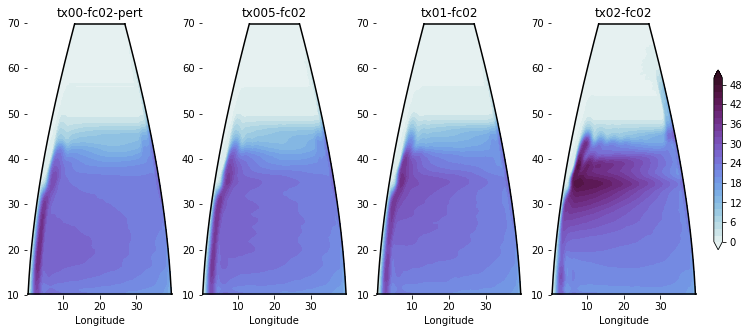

In [19]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,50,26)
ii=0
variable = 'vh_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

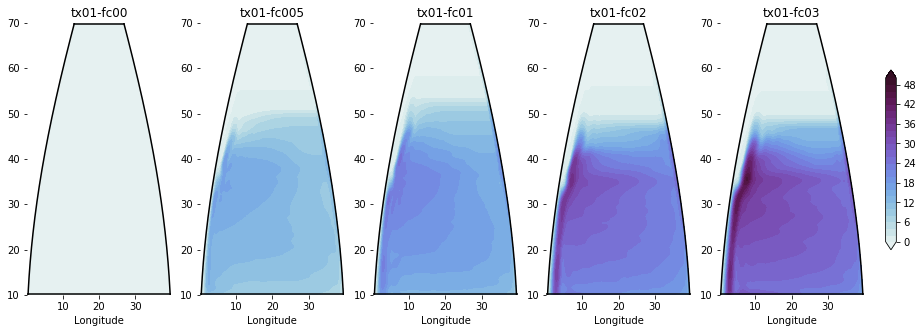

In [20]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(0,50,26)
ii=0
variable = 'vh_rho'
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

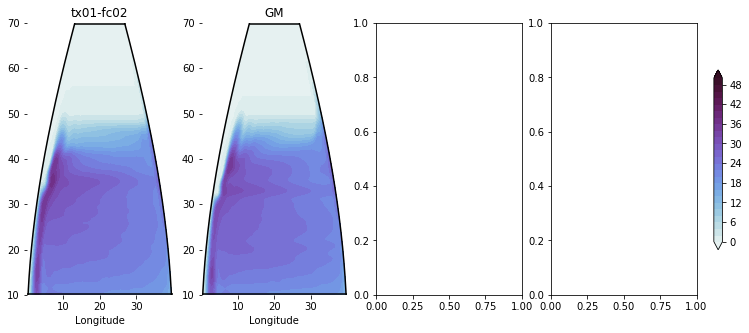

In [21]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,50,26)
ii=0
variable = 'vh_rho'
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    start_time = exptdict[ekey]['start_time']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(c) GM Expts')

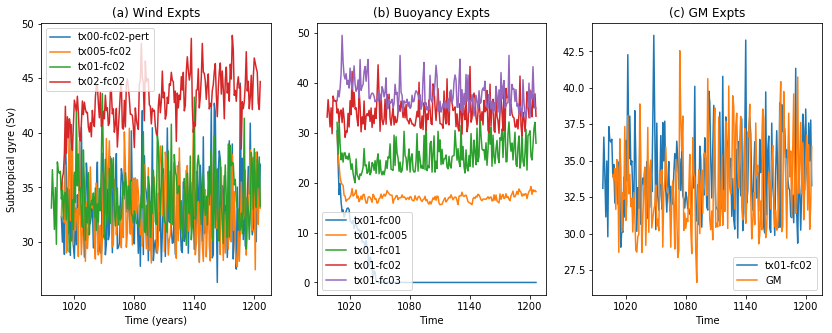

In [4]:
plt.figure(figsize=(14,5))
variable = 'vh_rho'
plt.subplot(131)
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)  
plt.legend()
plt.ylabel('Subtropical gyre (Sv)')
plt.xlabel('Time (years)')
plt.title('(a) Wind Expts')


plt.subplot(132)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(b) Buoyancy Expts')
plt.subplot(133)
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(c) GM Expts')

## Lower ocean streamfunction

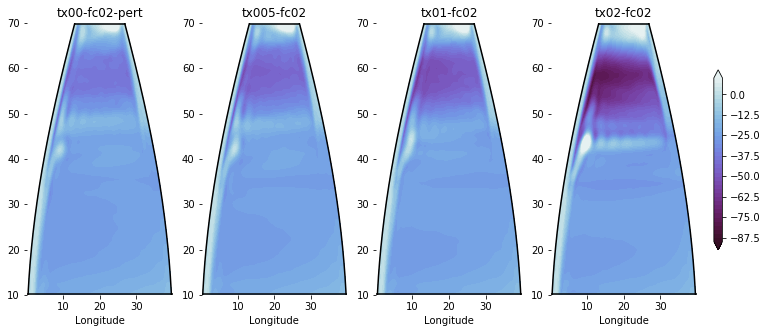

In [36]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-90,10,41)
ii=0
variable = 'vh_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense_r)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

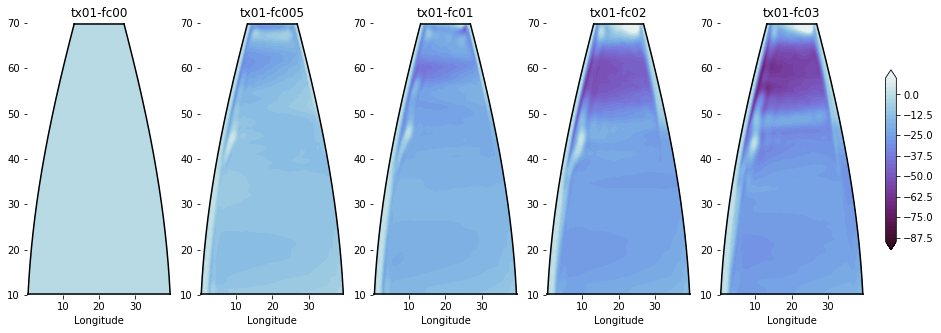

In [45]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(-90,10,41)
ii=0
variable = 'vh_rho'
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense_r)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

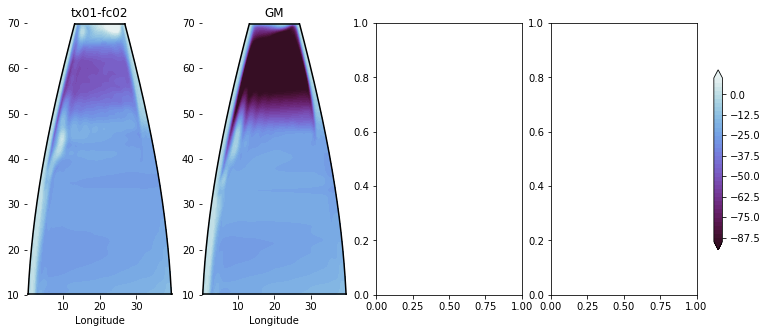

In [30]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-90,10,41)
ii=0
variable = 'vh_rho'
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.dense_r)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(c) GM Expts')

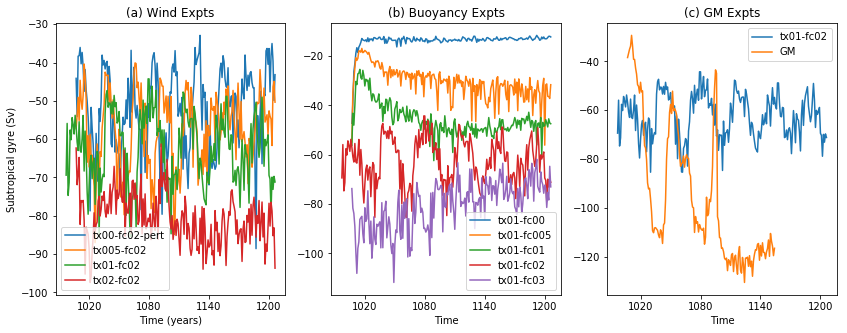

In [11]:
plt.figure(figsize=(14,5))
variable = 'vh_rho'
plt.subplot(131)
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)  
plt.legend()
plt.ylabel('Subtropical gyre (Sv)')
plt.xlabel('Time (years)')
plt.title('(a) Wind Expts')


plt.subplot(132)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(b) Buoyancy Expts')

plt.subplot(133)
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_lower_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.legend()
plt.ylabel('')
plt.title('(c) GM Expts')

## Overturning

Text(0.5,0,'')

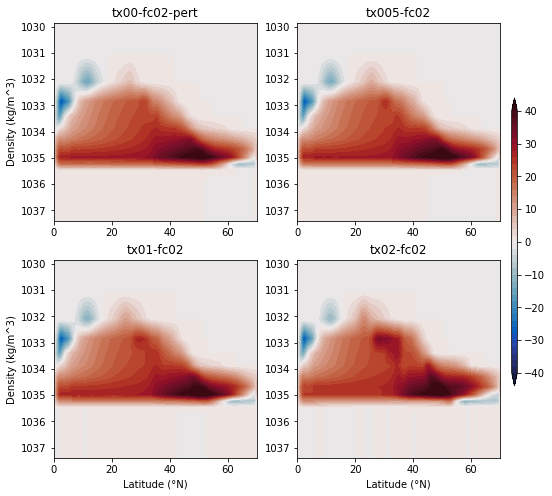

In [4]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
vlev = np.linspace(-40,40,41)
variable = 'vh_rho'
ii=0
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    p1 = psi.plot.contourf(ax=ax[np.int(ii/2),np.mod(ii,2)],levels=vlev,extend='both',cmap=cm.cm.balance,add_colorbar=False)
    ax[np.int(ii/2),np.mod(ii,2)].invert_yaxis()
    ax[np.int(ii/2),np.mod(ii,2)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Density (kg/m^3)')
ax[1,0].set_ylabel('Density (kg/m^3)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,0].set_xlabel('Latitude (°N)')
ax[1,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

Text(0.5,0,'')

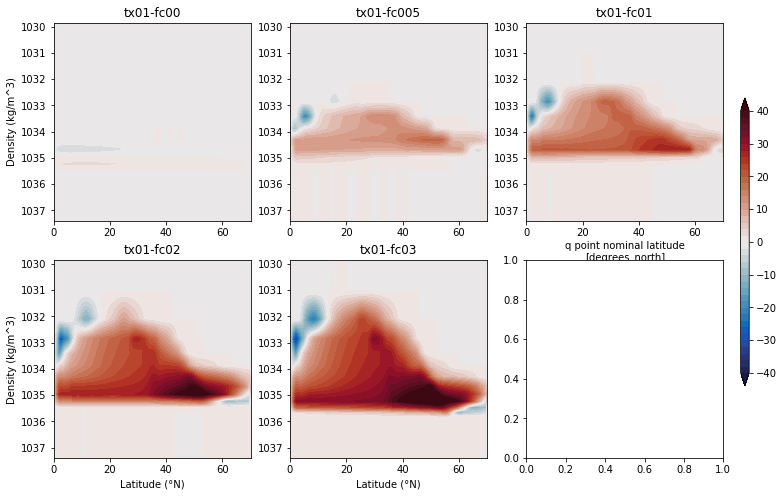

In [5]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
vlev = np.linspace(-40,40,41)
variable = 'vh_rho'
ii=0
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    p1 = psi.plot.contourf(ax=ax[np.int(ii/3),np.mod(ii,3)],levels=vlev,extend='both',cmap=cm.cm.balance,add_colorbar=False)
    ax[np.int(ii/3),np.mod(ii,3)].invert_yaxis()
    ax[np.int(ii/3),np.mod(ii,3)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Density (kg/m^3)')
ax[1,0].set_ylabel('Density (kg/m^3)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,2].set_ylabel('')
ax[1,0].set_xlabel('Latitude (°N)')
ax[1,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

Text(0.5,0,'')

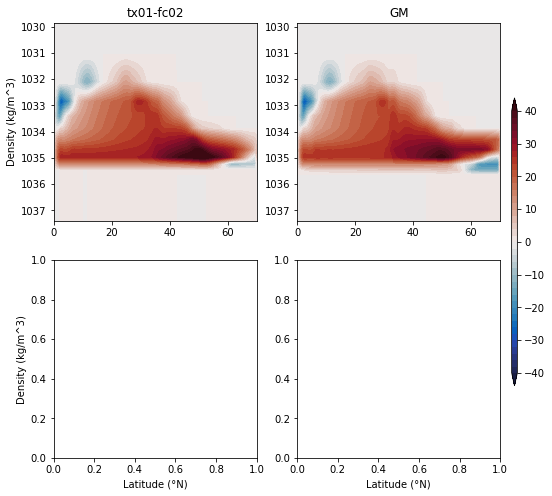

In [6]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
vlev = np.linspace(-40,40,41)
variable = 'vh_rho'
ii=0
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    p1 = psi.plot.contourf(ax=ax[np.int(ii/2),np.mod(ii,2)],levels=vlev,extend='both',cmap=cm.cm.balance,add_colorbar=False)
    ax[np.int(ii/2),np.mod(ii,2)].invert_yaxis()
    ax[np.int(ii/2),np.mod(ii,2)].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)
ax[0,0].set_ylabel('Density (kg/m^3)')
ax[1,0].set_ylabel('Density (kg/m^3)')
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[1,0].set_xlabel('Latitude (°N)')
ax[1,1].set_xlabel('Latitude (°N)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')

Text(0.5,1,'(c) GM Expts')

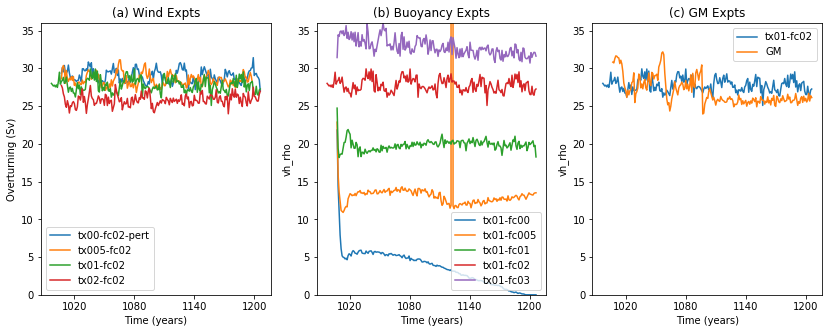

In [5]:
plt.figure(figsize=(14,5))
variable = 'vh_rho'

plt.subplot(131)
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.ylim(ymin=0,ymax=36)
plt.legend()
plt.ylabel('Overturning (Sv)')
plt.xlabel('Time (years)')
plt.title('(a) Wind Expts')

plt.subplot(132)
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)     
plt.ylim(ymin=0,ymax=36)
plt.legend()
plt.xlabel('Time (years)')
plt.title('(b) Buoyancy Expts')

plt.subplot(133)
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.plot(label=ekey)    
plt.ylim(ymin=0,ymax=36)
plt.legend()
plt.xlabel('Time (years)')
plt.title('(c) GM Expts')

## Barotropic streamfunction

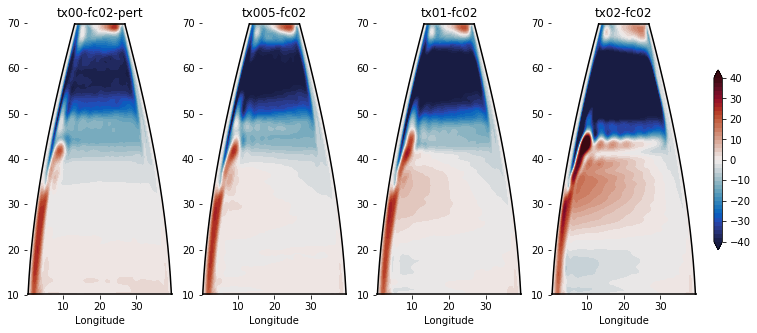

In [8]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-40,40,41)
ii=0
variable = 'vh_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

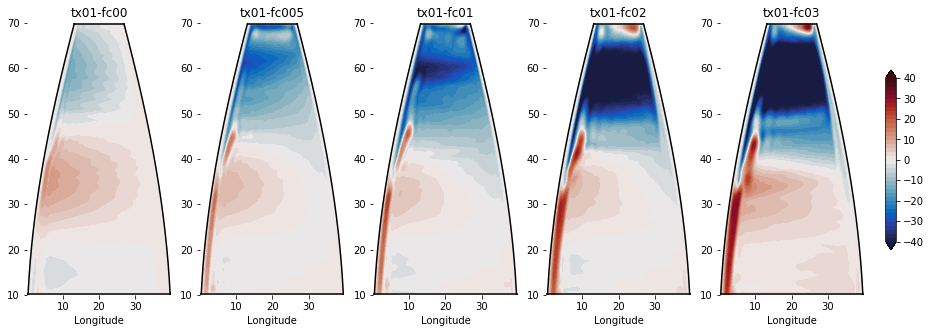

In [15]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(-40,40,41)
ii=0
variable = 'vh_rho'
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

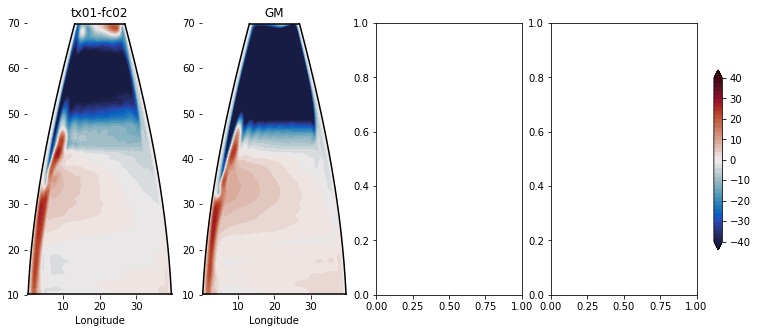

In [10]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(-40,40,41)
ii=0
variable = 'vh_rho'
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    X,Y = plot_mercator(ax[ii],psi.coords['xh'],psi.coords['yq'])
    p1=ax[ii].contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.balance)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

Text(0.5,1,'(f) GM Expts: $\\psi_{BT}$ Maximum')

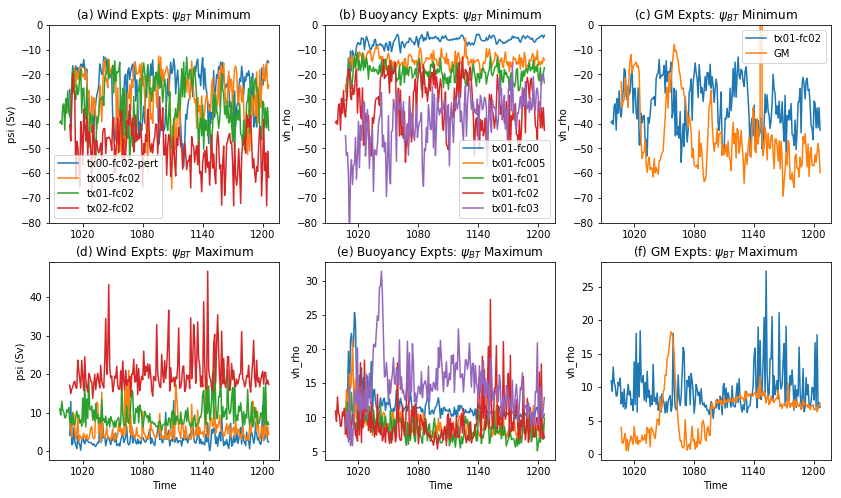

In [37]:
fig,ax = plt.subplots(2,3,figsize=(14,8))
variable = 'vh_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psimin = xr.open_dataset(FileName).vh_rho
    psimin.plot(ax=ax[0,0], label=ekey)
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psimax = xr.open_dataset(FileName).vh_rho
    psimax.plot(ax=ax[1,0], label=ekey)
                
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psimin = xr.open_dataset(FileName).vh_rho
    psimin.plot(ax=ax[0,1], label=ekey)
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psimax = xr.open_dataset(FileName).vh_rho
    psimax.plot(ax=ax[1,1], label=ekey)
                
                
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psimin = xr.open_dataset(FileName).vh_rho
    psimin.plot(ax=ax[0,2], label=ekey)
    FileName = processed+expt+'/'+variable+'_barotropic_max_timeseries.nc'
    psimax = xr.open_dataset(FileName).vh_rho
    psimax.plot(ax=ax[1,2], label=ekey)

ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[0,0].set_ylim(ymin=-80,ymax=0)
ax[0,1].set_ylim(ymin=-80,ymax=0)
ax[0,2].set_ylim(ymin=-80,ymax=0)
ax[0,0].set_ylabel('psi (Sv)')
ax[1,0].set_ylabel('psi (Sv)')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,2].set_xlabel('')
ax[0,0].set_title('(a) Wind Expts: $\psi_{BT}$ Minimum')
ax[0,1].set_title('(b) Buoyancy Expts: $\psi_{BT}$ Minimum')
ax[0,2].set_title('(c) GM Expts: $\psi_{BT}$ Minimum')
ax[1,0].set_title('(d) Wind Expts: $\psi_{BT}$ Maximum')
ax[1,1].set_title('(e) Buoyancy Expts: $\psi_{BT}$ Maximum')
ax[1,2].set_title('(f) GM Expts: $\psi_{BT}$ Maximum')

## Stratification

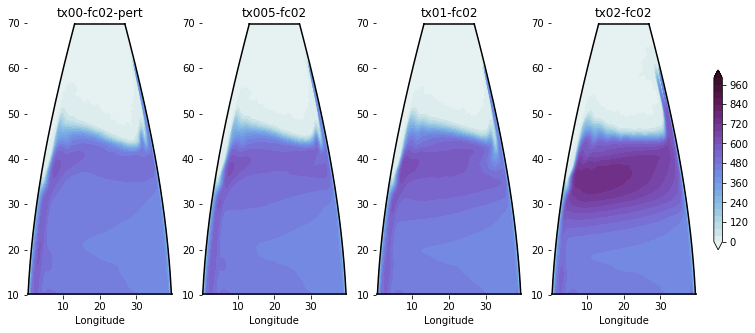

In [31]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,1000,26)
ii=0
variable = 'h_rho'
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_1034_averaged.nc'
    h = xr.open_dataset(FileName).h_rho
    X,Y = plot_mercator(ax[ii],h.coords['xh'],h.coords['yh'])
    p1=ax[ii].contourf(X,Y,h,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

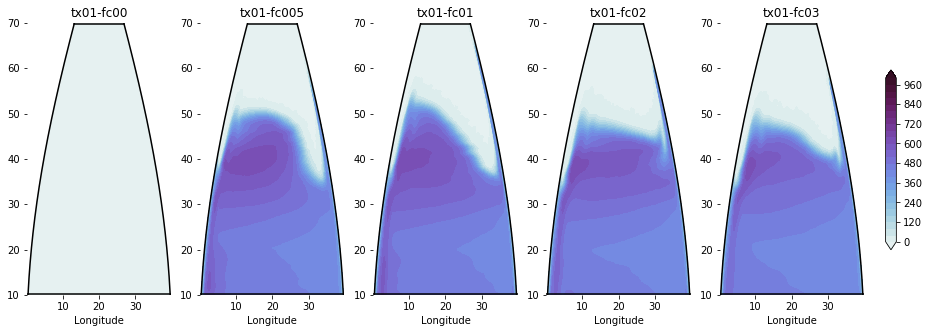

In [32]:
fig, ax = plt.subplots(1,5,figsize=(15,5))
vlev = np.linspace(0,1000,26)
ii=0
variable = 'h_rho'
for ekey in buoy_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_1034_averaged.nc'
    h = xr.open_dataset(FileName).h_rho
    X,Y = plot_mercator(ax[ii],h.coords['xh'],h.coords['yh'])
    p1=ax[ii].contourf(X,Y,h,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)

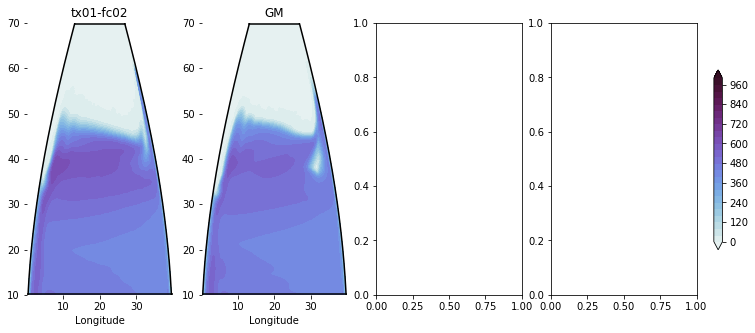

In [33]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
vlev = np.linspace(0,1000,26)
ii=0
variable = 'h_rho'
for ekey in GM_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_1034_averaged.nc'
    h = xr.open_dataset(FileName).h_rho
    X,Y = plot_mercator(ax[ii],h.coords['xh'],h.coords['yh'])
    p1=ax[ii].contourf(X,Y,h,levels=vlev,extend='both',cmap=cm.cm.dense)
    ax[ii].set_title(ekey)
    ii+=1
cax=plt.axes([0.92,0.25,0.01,.5])
plt.colorbar(p1,cax=cax)